In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import statsmodels.api as sm

### 1. Load and preprocess data

In [36]:
df = pd.read_csv('Salary_Data.csv')

# Quick view
print("Data preview:")
print(df.head())
print("\nData types:")
print(df.dtypes)

# Encode categorical variables
le_gender = LabelEncoder()
df['Gender_enc'] = le_gender.fit_transform(df['Gender'])  # Female=0, Male=1

edu_map = {"Bachelor's": 1, "Master's": 2, "PhD": 3}
df['Education_enc'] = df['Education Level'].map(edu_map)

# If any NaNs after mapping, drop them (small dataset)
df = df.dropna().reset_index(drop=True)

# Numeric features we will use
numeric_cols = ['Age', 'Years of Experience', 'Salary', 'Education_enc', 'Gender_enc']
print("\nNumeric columns used:", numeric_cols)

Data preview:
    Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0  

Data types:
Age                    float64
Gender                  object
Education Level         object
Job Title               object
Years of Experience    float64
Salary                 float64
dtype: object

Numeric columns used: ['Age', 'Years of Experience', 'Salary', 'Education_enc', 'Gender_enc']


### 2. Plots (box, violin, hist, density, contour)

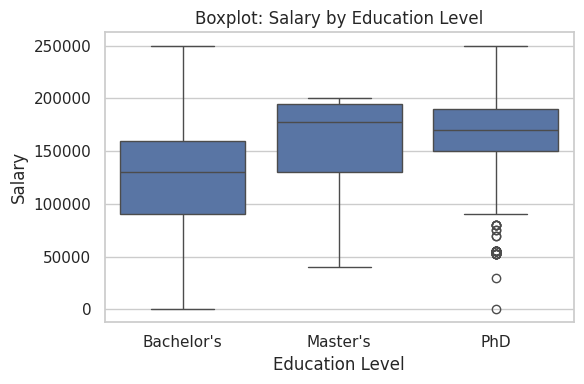

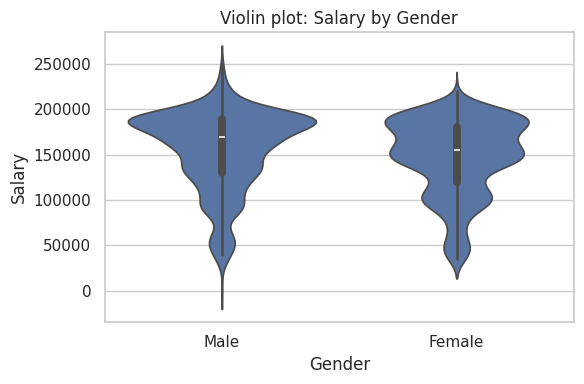

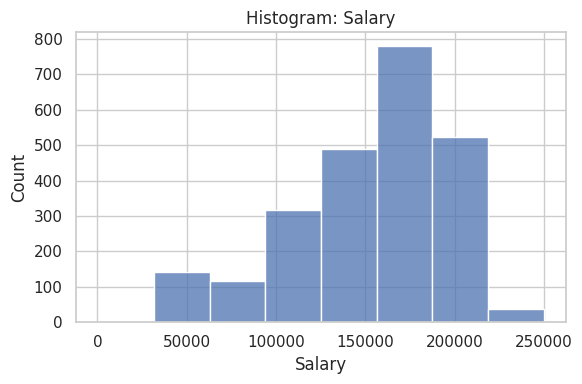

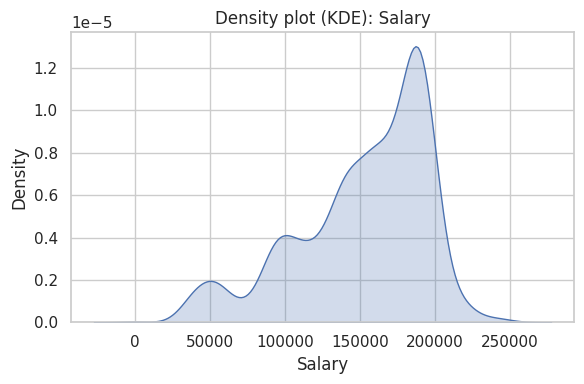

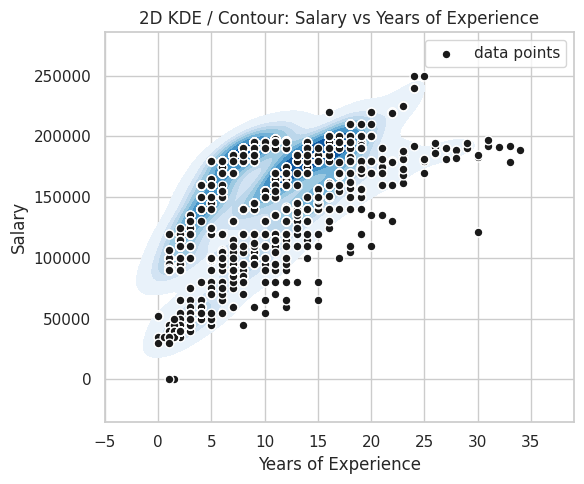

In [37]:
# Set seaborn theme
sns.set(style="whitegrid")

# Boxplot: Salary by Education Level (encoded)
plt.figure(figsize=(6,4))
sns.boxplot(x='Education Level', y='Salary', data=df, order=["Bachelor's","Master's","PhD"])
plt.title('Boxplot: Salary by Education Level')
plt.tight_layout()
plt.savefig('boxplot_salary_by_education.png')
plt.show()

# Violin plot: Salary by Gender
plt.figure(figsize=(6,4))
sns.violinplot(x='Gender', y='Salary', data=df)
plt.title('Violin plot: Salary by Gender')
plt.tight_layout()
plt.savefig('violin_salary_by_gender.png')
plt.show()

# Histogram: Salary
plt.figure(figsize=(6,4))
sns.histplot(df['Salary'], bins=8, kde=False)
plt.title('Histogram: Salary')
plt.xlabel('Salary')
plt.tight_layout()
plt.savefig('hist_salary.png')
plt.show()

# Density plot (KDE): Salary
plt.figure(figsize=(6,4))
sns.kdeplot(df['Salary'], fill=True)
plt.title('Density plot (KDE): Salary')
plt.xlabel('Salary')
plt.tight_layout()
plt.savefig('density_salary.png')
plt.show()

# Contour plot / 2D KDE: Salary vs Years of Experience
plt.figure(figsize=(6,5))
x = df['Years of Experience']
y = df['Salary']
sns.kdeplot(x=x, y=y, fill=True, cmap="Blues", thresh=0.05, levels=8)
plt.scatter(x, y, s=40, c='k', edgecolor='white', label='data points')
plt.title('2D KDE / Contour: Salary vs Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.legend()
plt.tight_layout()
plt.savefig('contour_salary_vs_experience.png')
plt.show()

### 3. Correlations


Pearson correlation between Age and Salary: r = 0.5351, p = 0.0000

Correlation matrix (numeric columns):
                          Age  Years of Experience    Salary  Education_enc  \
Age                  1.000000             0.925084  0.535130       0.592128   
Years of Experience  0.925084             1.000000  0.635118       0.615406   
Salary               0.535130             0.635118  1.000000       0.416488   
Education_enc        0.592128             0.615406  0.416488       1.000000   
Gender_enc           0.161583             0.101464  0.093479       0.034019   

                     Gender_enc  
Age                    0.161583  
Years of Experience    0.101464  
Salary                 0.093479  
Education_enc          0.034019  
Gender_enc             1.000000  


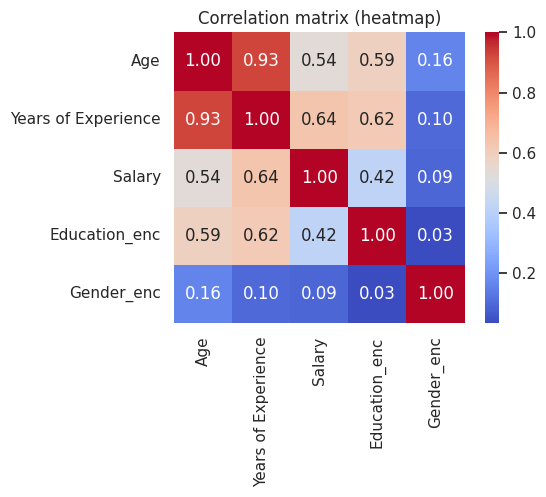

In [38]:
# Pick two attributes: Age and Salary (example)
attr1 = 'Age'
attr2 = 'Salary'
pearson_r, pearson_p = stats.pearsonr(df[attr1], df[attr2])
print(f"\nPearson correlation between {attr1} and {attr2}: r = {pearson_r:.4f}, p = {pearson_p:.4f}")

# Correlation matrix (Pearson) for numeric columns
corr_matrix = df[numeric_cols].corr()
print("\nCorrelation matrix (numeric columns):")
print(corr_matrix)

# Heatmap of correlation matrix
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation matrix (heatmap)')
plt.tight_layout()
plt.savefig('corr_matrix_heatmap.png')
plt.show()

### 4. PCA on numeric features


PCA explained variance ratio (per component):
 PC1: 0.582
 PC2: 0.198
 PC3: 0.117
 PC4: 0.091
 PC5: 0.013

PCA component loadings (rows = PCs, cols = original features):
          Age  Years of Experience    Salary  Education_enc  Gender_enc
PC1  0.539095             0.555990  0.438274       0.444102    0.104597
PC2  0.018774            -0.052836 -0.024949      -0.163909    0.984564
PC3 -0.128256             0.006417  0.781651      -0.605326   -0.078177
PC4 -0.508569            -0.373518  0.425695       0.639680    0.106933
PC5 -0.658736             0.740625 -0.122877      -0.017229    0.046325
PC1 depends mostly on: ['Years of Experience', 'Age', 'Education_enc']
PC2 depends mostly on: ['Gender_enc', 'Education_enc', 'Years of Experience']
PC3 depends mostly on: ['Salary', 'Education_enc', 'Age']
PC4 depends mostly on: ['Education_enc', 'Age', 'Salary']
PC5 depends mostly on: ['Years of Experience', 'Age', 'Salary']


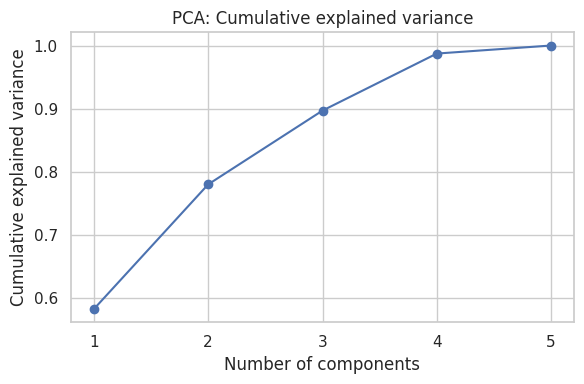

In [39]:
X = df[numeric_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=min(X_scaled.shape[0], X_scaled.shape[1]))
pca.fit(X_scaled)
explained = pca.explained_variance_ratio_
components = pca.components_

print("\nPCA explained variance ratio (per component):")
for i, var in enumerate(explained, start=1):
    print(f" PC{i}: {var:.3f}")

# Show component loadings as DataFrame
comp_df = pd.DataFrame(components, columns=numeric_cols)
comp_df.index = [f'PC{i}' for i in range(1, comp_df.shape[0]+1)]
print("\nPCA component loadings (rows = PCs, cols = original features):")
print(comp_df)

# Interpret main components: which features have largest absolute loadings
def interpret_pc(pc_series, top_n=3):
    s = pc_series.abs().sort_values(ascending=False)
    return list(s.index[:top_n])

for pc in comp_df.index:
    deps = interpret_pc(comp_df.loc[pc])
    print(f"{pc} depends mostly on: {deps}")

# Scree plot
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(explained)+1), explained.cumsum(), marker='o')
plt.xticks(np.arange(1, len(explained)+1))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA: Cumulative explained variance')
plt.grid(True)
plt.tight_layout()
plt.savefig('pca_scree.png')
plt.show()

### 5. Mode and Standard Error

In [40]:
# Mode for Salary (may be multiple modes)
modes_salary = df['Salary'].mode().tolist()
print("\nMode(s) of Salary:", modes_salary)

# For continuous-ish data with small sample, mode may not be meaningful; also show median
median_salary = df['Salary'].median()
mean_salary = df['Salary'].mean()
std_salary = df['Salary'].std(ddof=1)
n = len(df)
se_salary = std_salary / np.sqrt(n)

print(f"Mean salary: {mean_salary:.2f}")
print(f"Median salary: {median_salary:.2f}")
print(f"Std (sample): {std_salary:.2f}")
print(f"Standard Error of mean: {se_salary:.2f}")


Mode(s) of Salary: [185000.0]
Mean salary: 151895.19
Median salary: 160000.00
Std (sample): 43391.26
Standard Error of mean: 883.51


### 6. Distribution assessment

<Figure size 600x400 with 0 Axes>

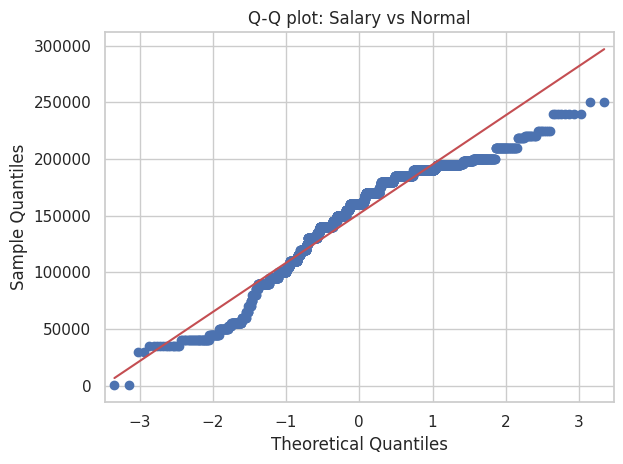


Shapiro-Wilk test for Salary: statistic=0.9248, p=0.0000
 -> Reject H0: data likely not normal (alpha=0.05)


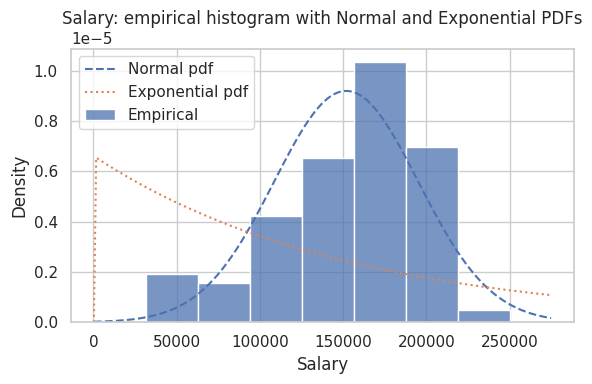


Distribution assessment notes:
 - Shapiro p-value indicates whether Normal is plausible.
 - Visual check: compare histogram / Q-Q plot and theoretical PDFs (normal vs exponential).
 - Small sample size (n=2412) limits power of tests; results are indicative, not definitive.


In [41]:
# Plot Q-Q plot for Salary vs Normal
plt.figure(figsize=(6,4))
sm.qqplot(df['Salary'], line='s', markersize=6)
plt.title('Q-Q plot: Salary vs Normal')
plt.tight_layout()
plt.savefig('qq_salary.png')
plt.show()

# Shapiro-Wilk test for normality (note: small sample, Shapiro is OK)
shapiro_stat, shapiro_p = stats.shapiro(df['Salary'])
print(f"\nShapiro-Wilk test for Salary: statistic={shapiro_stat:.4f}, p={shapiro_p:.4f}")
if shapiro_p < 0.05:
    print(" -> Reject H0: data likely not normal (alpha=0.05)")
else:
    print(" -> Fail to reject H0: data not inconsistent with normality")

# Visual compare: overlay theoretical pdfs (Normalized)
plt.figure(figsize=(6,4))
sns.histplot(df['Salary'], bins=8, stat='density', label='Empirical', kde=False)
# Normal pdf
x_vals = np.linspace(df['Salary'].min()*0.9, df['Salary'].max()*1.1, 200)
norm_pdf = stats.norm.pdf(x_vals, loc=mean_salary, scale=std_salary)
plt.plot(x_vals, norm_pdf, label='Normal pdf', linestyle='--')
# Exponential (shifted): fit lambda from data (use fit on positive data)
# We'll fit an exponential with loc=0 (non-shifted) for simplicity
exp_loc, exp_scale = stats.expon.fit(df['Salary'])
exp_pdf = stats.expon.pdf(x_vals, loc=exp_loc, scale=exp_scale)
plt.plot(x_vals, exp_pdf, label='Exponential pdf', linestyle=':')
plt.legend()
plt.title('Salary: empirical histogram with Normal and Exponential PDFs')
plt.tight_layout()
plt.savefig('salary_with_theoretical_pdfs.png')
plt.show()

print("\nDistribution assessment notes:")
print(" - Shapiro p-value indicates whether Normal is plausible.")
print(" - Visual check: compare histogram / Q-Q plot and theoretical PDFs (normal vs exponential).")
print(" - Small sample size (n={}) limits power of tests; results are indicative, not definitive.".format(n))

### 7. Bootstrap: 1000 resamples for mean Salary & 95% CI


Bootstrap (B=1000) mean of Salary: 151908.15
95% bootstrap CI for mean Salary: [150139.84, 153661.76]
Bootstrap standard error of mean: 900.02


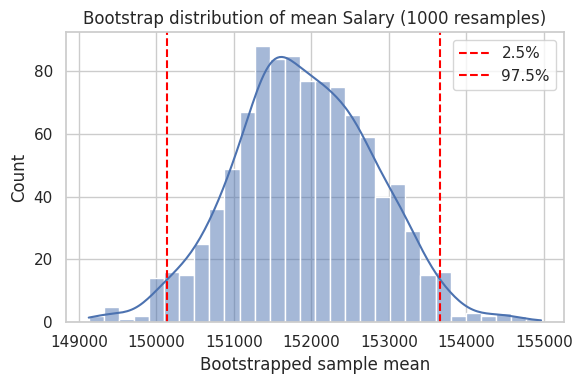

In [42]:
rng = np.random.default_rng(seed=42)
B = 1000
boot_means = []
salary_arr = df['Salary'].values
for i in range(B):
    sample = rng.choice(salary_arr, size=len(salary_arr), replace=True)
    boot_means.append(np.mean(sample))
boot_means = np.array(boot_means)

ci_lower = np.percentile(boot_means, 2.5)
ci_upper = np.percentile(boot_means, 97.5)
boot_mean_est = boot_means.mean()
boot_std = boot_means.std(ddof=1)

print(f"\nBootstrap (B={B}) mean of Salary: {boot_mean_est:.2f}")
print(f"95% bootstrap CI for mean Salary: [{ci_lower:.2f}, {ci_upper:.2f}]")
print(f"Bootstrap standard error of mean: {boot_std:.2f}")

# Plot bootstrap distribution
plt.figure(figsize=(6,4))
sns.histplot(boot_means, bins=30, kde=True)
plt.axvline(ci_lower, color='red', linestyle='--', label='2.5%')
plt.axvline(ci_upper, color='red', linestyle='--', label='97.5%')
plt.title('Bootstrap distribution of mean Salary (1000 resamples)')
plt.xlabel('Bootstrapped sample mean')
plt.legend()
plt.tight_layout()
plt.savefig('bootstrap_mean_salary.png')
plt.show()

### 8. Prepare markdown report (concise)

In [43]:
report_md = f"""
# Exploratory Analysis & Inference — Salary_Data.csv

## Dataset
N = {n} rows. Numeric columns used: {', '.join(numeric_cols)}.

## Visualizations (files saved):
- Boxplot by education: `boxplot_salary_by_education.png`
- Violin by gender: `violin_salary_by_gender.png`
- Histogram: `hist_salary.png`
- Density (KDE): `density_salary.png`
- 2D KDE / Contour (Salary vs Years of Experience): `contour_salary_vs_experience.png`
- Correlation heatmap: `corr_matrix_heatmap.png`
- PCA scree: `pca_scree.png`
- Q-Q plot: `qq_salary.png`
- PDFs overlay: `salary_with_theoretical_pdfs.png`
- Bootstrap hist: `bootstrap_mean_salary.png`

## Correlations
- Pearson r between Age and Salary: {pearson_r:.4f} (p = {pearson_p:.4f})
- Correlation matrix (numeric):
{corr_matrix.to_markdown()}

## PCA (numeric features standardized)
Explained variance ratio (per PC):
{', '.join([f'PC{i+1}: {v:.3f}' for i,v in enumerate(explained)])}

Top loadings per PC:
{comp_df.to_markdown()}

(Interpretation: each PC shows which original features contribute strongly via loadings. See printed loadings for details.)

## Mode & Standard Error
- Mode(s) of Salary: {modes_salary}
- Mean salary: {mean_salary:.2f}
- Median salary: {median_salary:.2f}
- Sample std: {std_salary:.2f}
- Standard error of mean: {se_salary:.2f}

## Distribution assessment
- Shapiro-Wilk test: statistic={shapiro_stat:.4f}, p={shapiro_p:.4f}
  - {'Normality plausible' if shapiro_p >= 0.05 else 'Normality unlikely (reject H0 at alpha=0.05)'}
- Visual checks: histogram, Q-Q plot, and overlayed Normal & Exponential pdfs were produced.
- Conclusion: given small sample (n={n}) and the visible right-skew (presence of large Salary values), the salary distribution appears **right-skewed** and is closer to an **exponential-like** / positively skewed distribution than to an ideal Gaussian. (Log-normal would be a natural candidate but is not in the supplied list.)

## Bootstrap (B={B})
- Bootstrap mean (avg of bootstrap means): {boot_mean_est:.2f}
- 95% bootstrap CI for mean Salary: [{ci_lower:.2f}, {ci_upper:.2f}]
- Bootstrap SE of mean: {boot_std:.2f}

## Final conclusions
1. The sample is very small (n={n}); any inference is indicative only.  
2. Salary shows right-skew; education level and years of experience are important predictors (see PCA and correlations).  
3. The bootstrap CI gives a robust, distribution-free interval for the mean salary given the observed sample.  
4. For stronger conclusions, collect a larger sample and consider transforming Salary (log) or modeling with skew-aware distributions.

"""
print(report_md)


# Exploratory Analysis & Inference — Salary_Data.csv

## Dataset
N = 2412 rows. Numeric columns used: Age, Years of Experience, Salary, Education_enc, Gender_enc.

## Visualizations (files saved):
- Boxplot by education: `boxplot_salary_by_education.png`
- Violin by gender: `violin_salary_by_gender.png`
- Histogram: `hist_salary.png`
- Density (KDE): `density_salary.png`
- 2D KDE / Contour (Salary vs Years of Experience): `contour_salary_vs_experience.png`
- Correlation heatmap: `corr_matrix_heatmap.png`
- PCA scree: `pca_scree.png`
- Q-Q plot: `qq_salary.png`
- PDFs overlay: `salary_with_theoretical_pdfs.png`
- Bootstrap hist: `bootstrap_mean_salary.png`

## Correlations
- Pearson r between Age and Salary: 0.5351 (p = 0.0000)
- Correlation matrix (numeric):
|                     |      Age |   Years of Experience |   Salary |   Education_enc |   Gender_enc |
|:--------------------|---------:|----------------------:|---------:|----------------:|-------------:|
| Age                 | 